## Activation function

### Relu function (Rectified linar unit)

In [1]:
import torch
from d2l import torch as d2l

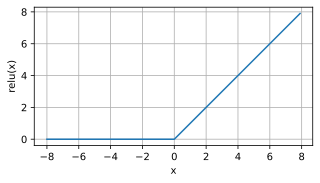

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)',  figsize=(5, 2.5))

# When x is 0, the derivate is considered zero as default.

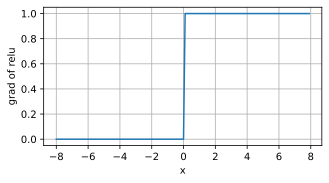

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad.detach(), 'x', 'grad of relu', figsize=(5, 2.5))

ReLU函数有许多变体，包括*参数化ReLU*（Parameterized ReLU，*pReLU*）
函数,该变体为ReLU添加了一个线性项，因此即使参数是负的，某些信息仍然可以通过：

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

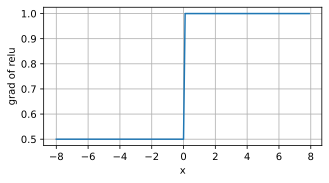

In [4]:
x.grad.data.zero_()
y = torch.prelu(x, weight=torch.tensor([0.5]))  # alpha = 0.5
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad.detach(), 'x', 'grad of relu', figsize=(5, 2.5))

### Sigmoid function

**$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$**

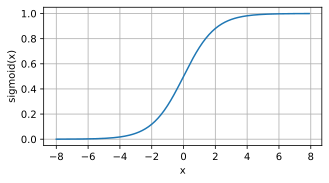

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

sigmoid函数的导数为下面的公式：

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$

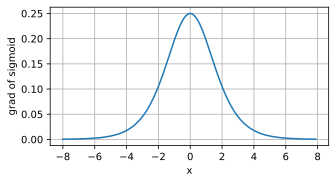

In [6]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad.detach(), 'x', 'grad of sigmoid', figsize=(5, 2.5))

### tanh function

**$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$**

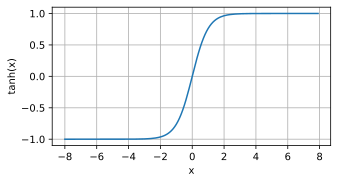

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$


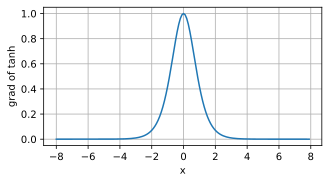

In [8]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## MLP

In [9]:
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

In [10]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [11]:
# Two layers of network
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [13]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [14]:
loss = nn.CrossEntropyLoss(reduction='none')

#### Something Achieved before but not in package d2l as expected

In [15]:
from IPython import display

In [16]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [18]:
def evaluate_accuracy(net, data_iter):  # Test
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
            


In [20]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [21]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc 

#### Continue

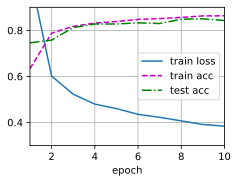

In [22]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [23]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels((net(X).argmax(axis=1)))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n]
    )

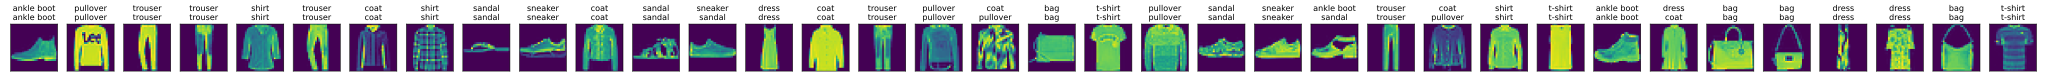

In [24]:
predict_ch3(net, test_iter, n=36)

#### Some test for setting hyperparameters(num_hiddens)

In [25]:
num_hiddens = 64

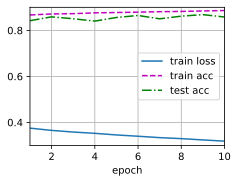

In [26]:
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

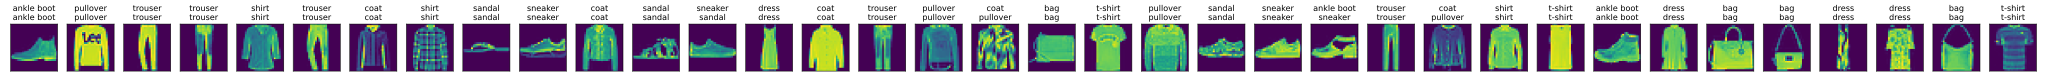

In [27]:
predict_ch3(net, test_iter, n=36)

## Simple API Implement about MLP

In [28]:
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [30]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

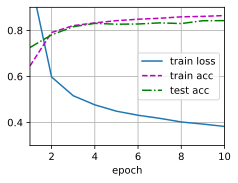

In [31]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Regression of Polynominal 

In [32]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

In [33]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [34]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [35]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [36]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False)) # Bias 已设置
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                        xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                        legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
            print('weight:', net[0].weight.data.numpy()) 

### Normal Fit

weight: [[ 4.980606   1.1946989 -3.4041991  5.591748 ]]


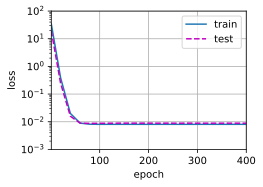

In [37]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### Underfitting

weight: [[3.1982412 4.8703737]]


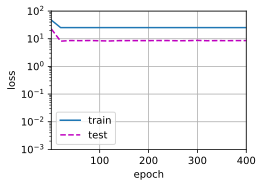

In [38]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### Overfitting

weight: [[ 4.9881682   1.3106056  -3.410075    5.087979   -0.14948882  0.9423797
   0.64312875  0.03926179  0.31730843 -0.19358289 -0.08908741  0.1635349
   0.018554   -0.10556324  0.14999159  0.15765525  0.18776663 -0.1412789
  -0.06699005  0.03711166]]


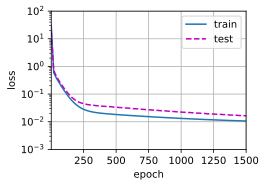

In [39]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

### Image of loss changing with the change of Degree

In [40]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False)) # Bias 已设置
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    for _ in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
    print('weight:', net[0].weight.data.numpy())
    return evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)

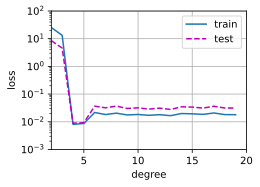

In [41]:
animator = Animator(xlabel='degree', ylabel='loss', yscale='log', 
                        xlim=[2, max_degree], ylim=[1e-3, 1e2], 
                        legend=['train', 'test'])
for i in range(2, max_degree):
  train_loss, test_loss = train(poly_features[:n_train, :i], poly_features[n_train:, :i], labels[:n_train], labels[n_train:])
  animator.add(i, (train_loss, test_loss))

## Weight Decay

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

In [42]:
import torch
from torch import nn
from d2l import torch as d2l

### One Example 

$$
y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon  \text{ where } 
\epsilon \sim \mathcal{N}(0, 0.01^2).
$$

In [43]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False) 

In [44]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [45]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2 

In [46]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是: ', torch.norm(w).item())

w的L2范数是:  14.403369903564453


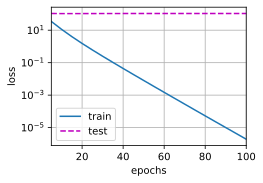

In [47]:
train(lambd=0)

w的L2范数是:  0.3602323532104492


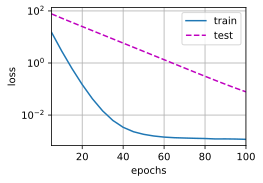

In [48]:
train(lambd=3)

### Concise Implementation

In [49]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd},
        {"params":net[0].bias}], 
        lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数: ', net[0].weight.norm().item()) 

w的L2范数:  13.486946105957031


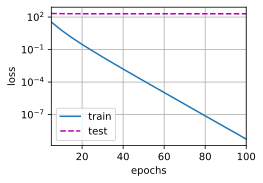

In [50]:
train_concise(0)

w的L2范数:  0.3901447653770447


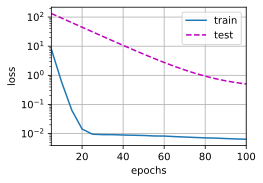

In [51]:
train_concise(3)

## Dropout

**暂退法**在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。
这种方法之所以被称为暂退法，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

In [52]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout) 

In [53]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  0.,  0., 12., 14.],
        [ 0., 18.,  0., 22., 24., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [54]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [55]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)


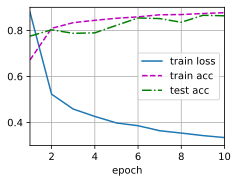

In [56]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### Simple Implement of dropout by API

In [57]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    # 添加第一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # 添加第二个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

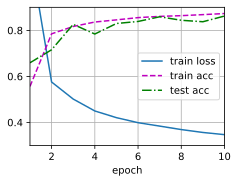

In [58]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### Exchange the possibility of dropout1 and dropout2 

In [59]:
diff_net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    # 添加第一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # 添加第二个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 10))

diff_net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

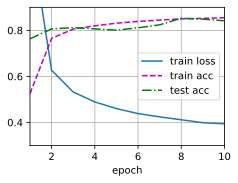

In [60]:
trainer = torch.optim.SGD(diff_net.parameters(), lr=lr)
train_ch3(diff_net, train_iter, test_iter, loss, num_epochs, trainer)

画一个前向、后向传播的计算图

## Vanishing grad & Exploding grad

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

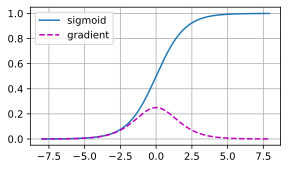

In [61]:
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [62]:
M = torch.normal(0, 1, size=(4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后 \n', M)

一个矩阵 
 tensor([[ 0.1666, -1.0371, -0.2417,  0.5101],
        [ 1.1868,  0.2657,  0.9729,  0.3006],
        [-1.2904,  0.1385, -0.2508,  0.1489],
        [ 0.6687,  1.0848, -0.1243, -0.2502]])
乘以100个矩阵后 
 tensor([[ 1.2277e+23, -9.5526e+22,  8.5727e+22, -7.6700e+22],
        [ 1.7911e+22, -1.3937e+22,  1.2507e+22, -1.1190e+22],
        [ 4.7561e+22, -3.7009e+22,  3.3212e+22, -2.9715e+22],
        [-1.4352e+23,  1.1168e+23, -1.0022e+23,  8.9668e+22]])


## [Kaggle Competition Challenge](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

### Downloading Scripts

In [63]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [64]:
def download(name, cache_dir='data'):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} doesn't exist in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)  # 1MB
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [65]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar is able to decompress.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

### Preprocess

In [66]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [67]:
DATA_HUB['kaggle_house_train'] = ( 
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [68]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [69]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [70]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [71]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [72]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [73]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [74]:
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass  LotFrontage   LotArea  OverallQual  SaleCondition_Normal  \
0    0.067320    -0.184443 -0.217841     0.646073                  True   
1   -0.873466     0.458096 -0.072032    -0.063174                  True   
2    0.067320    -0.055935  0.137173     0.646073                  True   
3    0.302516    -0.398622 -0.078371     0.646073                 False   

   SaleCondition_Partial  SaleCondition_nan  
0                  False              False  
1                  False              False  
2                  False              False  
3                  False              False  


In [75]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(float)).float()
test_features = torch.tensor(all_features[n_train:].values.astype(float)).float()
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1).astype(float)).float()

### Baseline model (Linear)

In [76]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [77]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [78]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, wd, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.float(), y.float()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K-fold Cross-Validation

In [79]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return (X_train, y_train, X_valid, y_valid)

In [80]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}, 训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1, 训练log rmse0.132700, 验证log rmse0.144130
折2, 训练log rmse0.130011, 验证log rmse0.146689
折3, 训练log rmse0.128223, 验证log rmse0.142735
折4, 训练log rmse0.133799, 验证log rmse0.137497
折5, 训练log rmse0.126873, 验证log rmse0.166885
5-折验证: 平均训练log rmse: 0.130321, 平均验证log rmse: 0.147587


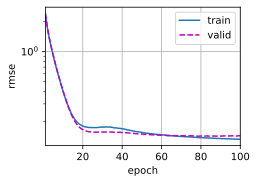

In [81]:
# k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 32  # Adjust the hyperparameters
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [82]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.128736


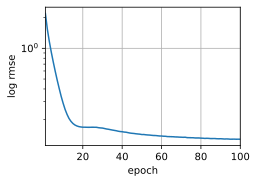

In [83]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

Before adjusting hyperparameters
Public Score: 0.14702

After adjusting hyperparameters 
Public Score: 0.14702

### Improved Model With One Hidden Layer 

In [84]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def get_net_complex():
    net = nn.Sequential(nn.Flatten(), nn.Linear(in_features, 512), nn.ReLU(), nn.Linear(512, 1))
    net.apply(init_weights)
    return net

In [85]:
def k_fold_complex(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net_complex()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.108804, 验证log rmse0.127367
折2，训练log rmse0.099937, 验证log rmse0.143942
折3，训练log rmse0.099519, 验证log rmse0.131850
折4，训练log rmse0.108456, 验证log rmse0.113913
折5，训练log rmse0.103847, 验证log rmse0.149858
5-折验证: 平均训练log rmse: 0.104112, 平均验证log rmse: 0.133386


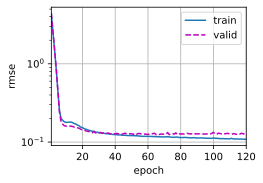

In [86]:
k, num_epochs, lr, weight_decay, batch_size = 5, 120, 0.01, 300, 32
train_l, valid_l = k_fold_complex(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [87]:
def train_and_pred_complex(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net_complex()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.107468


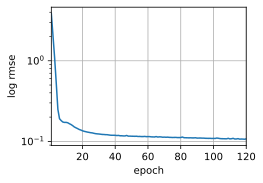

In [88]:
train_and_pred_complex(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

Public Score: 0.12240